# Short Text Clustering

The following work is mainly inspired by:
- 2014 - Convolutional Neural Networks for Sentence Classification
- 2014 - A Convolutional Neural Network for Modelling Sentences
- 2017 - Self-Taught Convolutional Neural Networks for Short Text Clustering

Word embedding from fasttext are distributed under the license:
- Creative Commons Attribution-Share-Alike License 3.0 (free commercial use)

# Import

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt

src_emb = "./embeddings/"
src_stc = "./data/short_texts/"

In [2]:
# Dataset for short text clustering
os.listdir(src_stc)

['SearchSnippets_gnd.txt',
 'Biomedical_gnd.txt',
 'StackOverflow.txt',
 'StackOverflow_gnd.txt',
 'Biomedical.txt',
 'labels.tsv',
 'SearchSnippets.txt']

In [3]:
# Word embedding 
os.listdir(src_emb)

['glove100K.100d.vec', 'fasttext.wiki.en.vec']

# Fetching the data

#### Loading pre-trained Fasttext word embedding

Pre-trained word vectors for french languages, trained on Wikipedia using fastText. These vectors in dimension `300` were obtained using the skip-gram model described in `Bojanowski et al.(2016)` with default parameters.

We extracted the `100 000` most frequent words. They have a dimension of `300`

In [4]:
%%time

fast_embeddings_index = dict()
fast_embeddings_vectors = list()
total = 1 * int(1e5)

tmp_emb = list()

with open(src_emb + 'fasttext.wiki.en.vec', 'rb') as f:
    head = f.readline().decode('utf-8')
    for word_idx in tqdm_notebook(range(total), total=total):
        raw = f.readline().decode('utf-8').rstrip(' \n')
        tmp_emb.append(raw + ' \n')
        line = raw.split(' ')
        word = line[0]
        vector = np.asarray(line[1:], dtype='float32')
        fast_embeddings_index[word] = word_idx
        fast_embeddings_vectors.append(vector)
        
fast_inv_index = {v: k for k, v in fast_embeddings_index.items()}
print("found %d different words in the file" % total)

Widget Javascript not detected.  It may not be installed or enabled properly.



found 100000 different words in the file
CPU times: user 9.29 s, sys: 759 ms, total: 10.1 s
Wall time: 9.35 s


In [5]:
# Storing each embedding model
embedding_model = {}
embedding_model['fasttext'] = [fast_embeddings_index, fast_embeddings_vectors, fast_inv_index]

# Word embedding

In [6]:
embedding_name = 'fasttext'
embeddings_index, embeddings_vectors, inv_index = embedding_model[embedding_name]

In [7]:
# Stack all embeddings in a large numpy array
embeddings = np.vstack(embeddings_vectors)
norms = np.linalg.norm(embeddings, axis=-1, keepdims=True)
embeddings_normed = embeddings / norms
print(embeddings.shape)

(100000, 300)


In [8]:
emb_shape = np.shape(embeddings[0])

def zeros_init():
    return np.zeros(shape=emb_shape)

def get_emb(word):
    idx = embeddings_index.get(word)
    if idx is None:
        return zeros_init()
    else:
        return embeddings[idx]

def get_normed_emb(word):
    idx = embeddings_index.get(word)
    if idx is None:
        return zeros_init()
    else:
        return embeddings_normed[idx]

In [9]:
epsilon = 1e-5

def most_similar(words, topn=10):
    query_emb = 0
    # If we have a list of words instead of one word
    if type(words) == list:
        for word in words:
            query_emb += get_emb(word)       
    else:
        query_emb = get_emb(words)
        
    query_emb = query_emb / (np.linalg.norm(query_emb) + epsilon)
    
    # Large numpy vector with all cosine similarities
    # between emb and all other words
    cosines = np.dot(embeddings_normed, query_emb)
    
    # topn most similar indexes corresponding to cosines
    idxs = np.argsort(cosines)[::-1][:topn]
    
    # pretty return with word and similarity
    return [(inv_index[idx], cosines[idx]) for idx in idxs]

In [10]:
most_similar('maths')

[('maths', 0.99999779),
 ('mathematics', 0.70726186),
 ('math', 0.70355946),
 ('gcse', 0.66205692),
 ('gcses', 0.60882723),
 ('igcse', 0.57441121),
 ('homework', 0.56958699),
 ('numeracy', 0.56879789),
 ('arithmetic', 0.54979843),
 ('physics', 0.54030263)]

In [11]:
most_similar('napoleon')

[('napoleon', 0.99999756),
 ('bonaparte', 0.77908337),
 ('napoléon', 0.71624571),
 ('napoleonic', 0.69677258),
 ('davout', 0.66151649),
 ('austerlitz', 0.6409688),
 ('masséna', 0.63768834),
 ('beauharnais', 0.63125008),
 ('soult', 0.62394291),
 ('talleyrand', 0.61470497)]

# Data exploration

#### Loading data

In [12]:
#data_name = "Biomedical"
data_name = "StackOverflow"

with open(src_stc + '%s.txt' % data_name, encoding="utf-8") as f:
    data = f.readlines()
data = [text.rstrip('\n') for text in data]

with open(src_stc + '%s_gnd.txt' % data_name, encoding="utf-8") as f:
    target = f.readlines()
target = [int(label.rstrip('\n')) for label in target]
    
print("short texts")
n_max = 10
__ = [print("%d --" %label, txt) for txt, label in zip(data[:n_max], target[:n_max])]
print("\n Total: %s texts" % format(len(data), ","))

short texts
18 -- How do I fill a DataSet or a DataTable from a LINQ query resultset ?
18 -- How do you page a collection with LINQ?
3 -- Best Subversion clients for Windows Vista (64bit)
3 -- Best Practice: Collaborative Environment, Bin Directory, SVN
7 -- Visual Studio Setup Project - Per User Registry Settings
18 -- How do I most elegantly express left join with aggregate SQL as LINQ query
7 -- .Net XML comment into API Documentation
15 -- Modify Address Bar URL in AJAX App to Match Current State
7 -- Integrating Visual Studio Test Project with Cruise Control
10 -- What should a longtime Windows user know when starting to use Linux?

 Total: 20,000 texts


In [13]:
# Random sample 

n = len(data)
sample = 10000
print("Loading %s samples" % format(sample, ","))
index_sample = np.random.randint(0, n, sample)

data = [data[idx] for idx in index_sample]
target = [target[idx] for idx in index_sample]

Loading 10,000 samples


In [14]:
most_similar('stackoverflow')

[('hemophilia', 0.0),
 ('penney', 0.0),
 ('leconte', 0.0),
 ('remodelled', 0.0),
 ('bdsm', 0.0),
 ('cité', 0.0),
 ('newry', 0.0),
 ('camberwell', 0.0),
 ('lightfoot', 0.0),
 ('outburst', 0.0)]

# Getting sequences and targets

Using TensorFlow backend.


Found 7033 unique tokens.
average length: 8.5
max length: 34


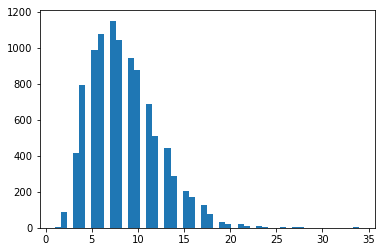

In [15]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(char_level=False)
tokenizer.fit_on_texts(data)
sequences_full = tokenizer.texts_to_sequences(data)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
MAX_NB_WORDS = len(word_index)

seq_lens = [len(s) for s in sequences_full]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))
plt.hist(seq_lens, bins=50);

MAX_SEQUENCE_LENGTH = max(seq_lens)

X = pad_sequences(sequences_full, maxlen=MAX_SEQUENCE_LENGTH)
y = target
tfidf = tokenizer.sequences_to_matrix(sequences_full, mode='tfidf')

In [16]:
# creating embedding matrix
EMBEDDING_DIM = emb_shape[0]
N_CLASSES = 21

# prepare embedding matrix
nb_words_in_matrix = 0
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = get_emb(word)
    embedding_matrix[i] = embedding_vector
    nb_words_in_matrix = nb_words_in_matrix + 1
        
print("added %d words in the embedding matrix" % nb_words_in_matrix)

added 7033 words in the embedding matrix


# Deep feature representations learning by CNN

#### Target vectors

In [17]:
# dict
Y = dict()

# dictionary of reduction methods' name
reduction_methods = {"le": "laplacian eigenvalues",
                     "ae": "average embeddings",
                     "lsa": "latent semantic analysis"}

#### Average embeddings (AE)

``
%%time
denom = 1 + np.sum(tfidf, axis=1)[:, None]
normed_tfidf = tfidf/denom
average_embeddings = np.dot(normed_tfidf, embedding_matrix)
Y["ae"] = average_embeddings
print("Shape of average embedding: ", Y['ae'].shape)
``

#### Latent Semantic Analysis (LSA)

In [18]:
from sklearn.pipeline import  make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

# self coded package
from utils.target import laplacian_eigenmaps, binarize

In [19]:
%%time
svd = TruncatedSVD(100)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
L = lsa.fit_transform(tfidf)
Y["lsa"] = L
print("Shape of latent semantic vectors: ", Y['lsa'].shape)

Shape of latent semantic vectors:  (10000, 100)
CPU times: user 24.9 s, sys: 454 ms, total: 25.4 s
Wall time: 1.88 s


#### Laplacian Eigenmaps (LE) [memory intensive]

In [20]:
%%time

# eigen vectors from graph of text similarity
E = laplacian_eigenmaps(L, n_neighbors=15, subdim=15, n_jobs=-1)
Y["le"] = E

Fitting nearest neighbors
Creation of affinity matrix
Creation of heat kernel affinity matrix
Spectral embedding
CPU times: user 4min 55s, sys: 1.88 s, total: 4min 57s
Wall time: 32.9 s


In [21]:
print(E.shape)
print()
print(E[0])

(10000, 15)

[-0.00916118 -0.00195615 -0.01133775 -0.0038497  -0.00715965 -0.01957486
 -0.00393287 -0.04443301 -0.03228334 -0.00925762  0.04993189 -0.01854278
 -0.02561074  0.01776686 -0.00644602]


#### Target vector: binary feature

In [22]:
reduction_name = "le"
B = binarize(Y[reduction_name])

# Last dimension in the CNN
LAST_DIMENSION = B.shape[1]

In [23]:
print(B.shape)
print()
print(B[0])

(10000, 15)

[ 0.  1.  0.  1.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  1.]


# CNN for deep feature representation learning 

Remarks:
- Two layers is better
- Activation tanh slightly better than relu
- Setting trainable layer to "True", we achieved in 10 epochs with batch=50 a very good performance (0.32 with current architecture)

To try:
- Use multiple layers

In [24]:
from keras.layers import Input, Embedding, Flatten, Reshape
from keras.layers import Dense, Conv1D, Dropout, merge
from keras.layers import GlobalAveragePooling1D, AveragePooling1D
from keras.layers import MaxPooling1D, GlobalMaxPooling1D, ZeroPadding1D
from keras.models import Model
from sklearn.metrics import accuracy_score

In [25]:
embedding_matrix_copy = embedding_matrix.copy()
trainable_embedding = False

# Embedding layer
pretrained_embedding_layer = Embedding(
    input_dim=MAX_NB_WORDS+1,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
)

# Input
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = pretrained_embedding_layer(sequence_input)

# 1st Layer
x = Conv1D(100, 5, activation='tanh', border_mode='same')(embedded_sequences)
x = GlobalMaxPooling1D()(x)

# Output
x = Dropout(0.5)(x)
predictions = Dense(LAST_DIMENSION, activation='sigmoid')(x)
model = Model(sequence_input, predictions)

# Fine-tune embeddings or not
model.layers[1].trainable=trainable_embedding

# Model hyper-parameters
losses = {'bc': 'binary_crossentropy',
          'cc': 'categorical_crossentropy',
          'mse': 'mse',
          'mae': 'mae',
         }

# Loss and Optimizer
loss_name = 'bc'
model.compile(loss=losses[loss_name],
              optimizer='adam',
              metrics=['mae'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 34)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 34, 300)           2110200   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 34, 100)           150100    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                1515      
Total params: 2,261,815
Trainable params: 151,615
Non-trainable params: 2,110,200
____________________________________________________________

/apps/anaconda/anaconda3/envs/willau/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(100, 5, activation="tanh", padding="same")`


In [26]:
%%time
nb_epoch = 1
model.fit(X, B, validation_split=0.2,
          epochs=nb_epoch, batch_size=100, verbose=2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/1
2s - loss: 0.6005 - mean_absolute_error: 0.4349 - val_loss: 0.5208 - val_mean_absolute_error: 0.3862
CPU times: user 18.4 s, sys: 2.91 s, total: 21.3 s
Wall time: 2.48 s


#### Deep feature representations h

In [27]:
from keras.models import Model

# take the penultimate layer
input = model.layers[0].input
output = model.layers[-2].output

# Take the output of the layer just before the AveragePooling2D
model_h = Model(input, output)

In [28]:
%%time
H = model_h.predict(X)

CPU times: user 6.42 s, sys: 815 ms, total: 7.23 s
Wall time: 1.53 s


In [29]:
print("Sample shape: {}".format(H.shape))

Sample shape: (10000, 100)


# Tools for evaluating cluster quality

In [30]:
from sklearn.preprocessing import normalize
from collections import Counter
from operator import itemgetter

def map_label(true_labels, pred_labels):
    label_pair = list(zip(pred_labels, true_labels))
    count = tuple(Counter(label_pair).items())
    mapping = dict()
    n_label = len(np.unique(true_labels))
    
    # Get most likely mapping based on counts
    for label in range(n_label):
        tuples = [tup for tup in count if tup[0][0] == label]
        likely_tuple = max(tuples, key=itemgetter(1))[0]
        mapping[likely_tuple[0]] = likely_tuple[1]

    pred_labels_mapped = [mapping[x] for x in pred_labels]
    return pred_labels_mapped

def cluster_quality(true_labels, pred_labels):    
    h, c, v = metrics.homogeneity_completeness_v_measure(true_labels, pred_labels)
    nmi = metrics.normalized_mutual_info_score(true_labels, pred_labels)
    rand = metrics.adjusted_rand_score(true_labels, pred_labels)
    print("Homogeneity: %0.3f" % h)
    print("Completeness: %0.3f" % c)
    print("V-measure: %0.3f" % v)
    print("NMI: %0.3f" % nmi)
    print("Rand: %0.3f" % rand)
    pred_labels_mapped = map_label(true_labels, pred_labels)
    acc = accuracy_score(true_labels, pred_labels_mapped)
    print("Acc: %0.3f" % acc)

# K-means on deep feature representations

In [31]:
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics
from sklearn.decomposition import PCA

# normalize deep feature representation
V = normalize(H, norm='l2')

In [32]:
%%time
#km = MiniBatchKMeans(n_clusters=20, init_size=1000, batch_size=1000, n_init=1)
km = KMeans(n_clusters=20, n_init=1)
km.fit(V)
pred_labels = km.labels_
true_labels = y

# Evaluate clustering
cluster_quality(true_labels, pred_labels)

Homogeneity: 0.608
Completeness: 0.618
V-measure: 0.613
NMI: 0.613
Rand: 0.464
Acc: 0.642
CPU times: user 2.86 s, sys: 70 ms, total: 2.93 s
Wall time: 194 ms


In [33]:
# parameters of deep feature representation learning
print("Deep feature learning parameters \n")

print("Number of epochs: %s" % nb_epoch)
print("Reduction name: %s" % reduction_methods[reduction_name])
print("Trainable word embedding layer: %s" % str(trainable_embedding))

Deep feature learning parameters 

Number of epochs: 1
Reduction name: laplacian eigenvalues
Trainable word embedding layer: False


# K-means on LSA

In [34]:
from sklearn.decomposition import TruncatedSVD

In [35]:
%%time
svd = TruncatedSVD(n_components=100)
LSA = svd.fit_transform(tfidf)
LSA = normalize(LSA)
print(LSA.shape)

(10000, 100)
CPU times: user 20.1 s, sys: 303 ms, total: 20.4 s
Wall time: 1.6 s


In [36]:
%%time

km = KMeans(n_clusters=20, n_init=1)
km.fit(LSA)
pred_labels = km.labels_
true_labels = y

# Evaluate clustering
cluster_quality(true_labels, pred_labels)

Homogeneity: 0.592
Completeness: 0.668
V-measure: 0.628
NMI: 0.629
Rand: 0.289
Acc: 0.643
CPU times: user 2.66 s, sys: 46 ms, total: 2.7 s
Wall time: 179 ms


# Cluster visualization

In [37]:
%matplotlib inline
from matplotlib import pyplot as plt
from webcolors import name_to_rgb
from sklearn.manifold import TSNE

color_names = ['SeaGreen', 'Sienna', 'Silver', 'Navy', 'Purple', 'SlateGrey', 'Orange',
               'SpringGreen', 'SteelBlue', 'Lime', 'Teal', 'Thistle', 'Tomato', 'Turquoise',
               'Violet', 'OrangeRed', 'Black', 'Red', 'Yellow', 'YellowGreen']

# number of samples to visualize because tsne is slow
n_sample = 2000
index_sample = np.random.randint(low=0, high=sample, size=(n_sample,))

# mapping color to sample
true_labels = y
labels = np.unique(true_labels)
colormap = {label: color for label, color in zip(labels, color_names)}
colors = [colormap[x] for x in true_labels[:n_sample]]

# plot function
def plot_tsne(T):
    color_rgb = [name_to_rgb(name) for name in colors]
    color_rgb_norm = [(x/255., y/255., z/255.) for x, y, z in color_rgb]
    plt.figure(figsize=(10, 10))
    plt.scatter(T[:, 0], T[:, 1], c=color_rgb_norm, s=60)

#### T-SNE embedding on deep feature representations

Remarks:
- Using Laplacian Eigenvalues, we obtain very dense clusters
- Using LSA as target, results are also quite good
- LSA is very competitive for accuracy

In [38]:
# T-SNE model
tsne = TSNE(n_components=2, 
            perplexity=30, early_exaggeration=4.,
            init="pca", metric="euclidean")

In [39]:
%%time
W = V[:n_sample]
T = tsne.fit_transform(W)

CPU times: user 36.8 s, sys: 2.8 s, total: 39.6 s
Wall time: 36.9 s


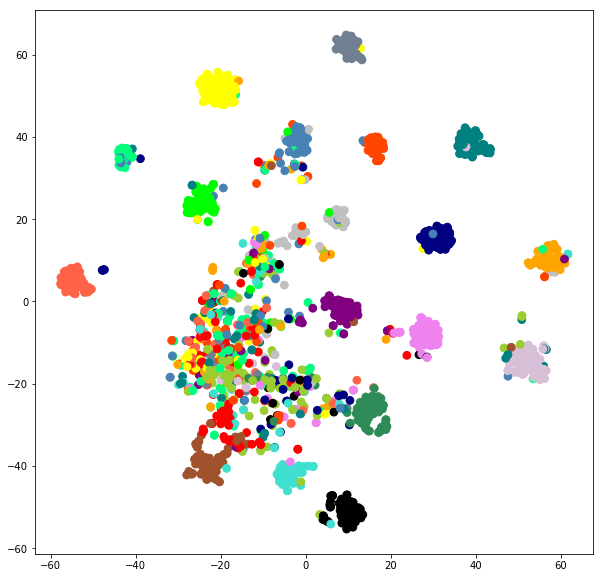

In [40]:
plot_tsne(T)

#### T-SNE embedding on LSA

In [41]:
%%time
L = tsne.fit_transform(LSA[:n_sample])

CPU times: user 37.4 s, sys: 3.1 s, total: 40.5 s
Wall time: 37.6 s


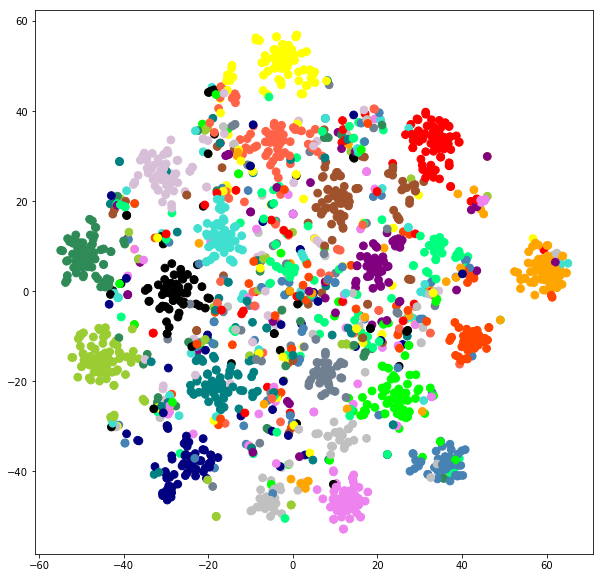

In [42]:
# matplotlib visualization
plot_tsne(L)

# Testing K-means on laplacian eigenvalues

In [43]:
%%time
NB = normalize(Y["le"])
km = KMeans(n_clusters=20, n_init=1)
km.fit(NB)
pred_labels = km.labels_
true_labels = y

# Evaluate clustering
cluster_quality(true_labels, pred_labels)

Homogeneity: 0.507
Completeness: 0.513
V-measure: 0.510
NMI: 0.510
Rand: 0.426
Acc: 0.644
CPU times: user 1.31 s, sys: 32 ms, total: 1.34 s
Wall time: 87.5 ms


In [44]:
%%time
LE = Y["le"]
TLE = tsne.fit_transform(LE[:n_sample])

CPU times: user 44.4 s, sys: 3.07 s, total: 47.5 s
Wall time: 42.6 s


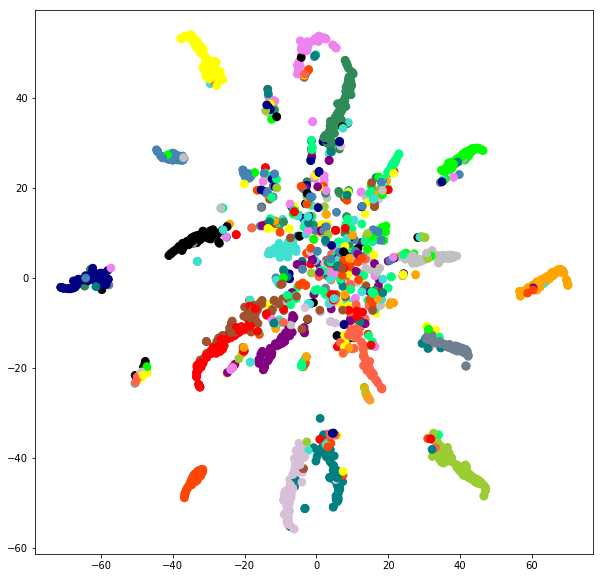

In [45]:
plot_tsne(TLE)